# MQTT-Integration mit Machine-Learning-Pipelines

## Inhaltsverzeichnis

1. [Einführung in MQTT](#introduction)
2. [Einrichten des MQTT-Clients](#setup)
3. [Generierung von simulierten Sensordaten](#mock-data)
4. [Datenerfassung und -speicherung](#data-collection)
5. [Machine-Learning-Pipeline](#ml-pipeline)
6. [Echtzeit-Vorhersagesystem](#real-time)
7. [Übungsaufgaben](#practice)

---

## 1. Einführung in MQTT {#introduction}

### Was ist MQTT?

MQTT (Message Queuing Telemetry Transport) ist ein leichtgewichtiger Messaging-Protokoll, das für IoT-Geräte und Anwendungen mit begrenzter Bandbreite entwickelt wurde. Es folgt einem Publish-Subscribe-Muster, bei dem:

- **Publisher** (Veröffentlicher) Nachrichten an Themen (Topics) senden
- **Subscriber** (Abonnenten) Nachrichten von Themen empfangen, an denen sie interessiert sind
- **Broker** als Vermittler fungiert und Nachrichten zwischen Publishern und Subscribern weiterleitet

### Warum MQTT für ML-Pipelines?

1. **Echtzeit-Datenstreaming**: Perfekt für kontinuierliche Sensordaten
2. **Leichtgewichtig**: Minimaler Overhead für IoT-Geräte
3. **Skalierbar**: Kann Tausende von Geräten verarbeiten
4. **Zuverlässig**: Quality of Service (QoS)-Stufen gewährleisten die Nachrichtenzustellung

### Struktur von MQTT-Themen

Themen verwenden eine hierarchische Struktur mit Schrägstrichen:
```
sensors/temperature/room1
sensors/humidity/room1
sensors/pressure/outdoor
factory/machine1/vibration
```

## 2. Einrichten des MQTT-Clients {#setup}

Zuerst installieren wir die erforderlichen Bibliotheken und richten unseren MQTT-Client ein.

In [1]:
# Benötigte Pakete installieren
!pip install paho-mqtt pandas numpy scikit-learn matplotlib seaborn plotly

import paho.mqtt.client as mqtt
import json
import time
import threading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Importe
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

# Plotting einrichten
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------- ----------------------------- 2.6/9.9 MB 12.5 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.9 MB 12.3 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/9.9 MB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 11.8 MB/s eta 0:00:00


### MQTT-Client-Konfiguration

Wir verwenden den öffentlichen Eclipse Mosquitto Broker für dieses Tutorial. In einer Produktionsumgebung würden Sie einen privaten Broker verwenden.

In [2]:
# MQTT-Konfiguration
MQTT_BROKER = "test.mosquitto.org"  # Öffentlicher Broker zum Testen
MQTT_PORT = 1883
MQTT_KEEPALIVE = 60

# Themen für unsere Sensoren
TOPICS = {
    'temperature': 'tutorial/sensors/temperature',
    'humidity': 'tutorial/sensors/humidity',
    'pressure': 'tutorial/sensors/pressure',
    'vibration': 'tutorial/sensors/vibration'
}

# Globale Datenspeicherung
sensor_data = []
data_lock = threading.Lock()

print(f"MQTT Broker: {MQTT_BROKER}:{MQTT_PORT}")
print(f"Themen: {list(TOPICS.values())}")

MQTT Broker: test.mosquitto.org:1883
Themen: ['tutorial/sensors/temperature', 'tutorial/sensors/humidity', 'tutorial/sensors/pressure', 'tutorial/sensors/vibration']


### MQTT-Client-Setup

Erstellen wir unseren MQTT-Client mit Callback-Funktionen, um Verbindungen und Nachrichten zu behandeln.

In [3]:
class MQTTDataCollector:
    def __init__(self, broker, port, topics):
        self.broker = broker
        self.port = port
        self.topics = topics
        self.client = mqtt.Client()
        self.data = []
        self.is_connected = False
        
        # Callbacks einrichten
        self.client.on_connect = self.on_connect
        self.client.on_message = self.on_message
        self.client.on_disconnect = self.on_disconnect
    
    def on_connect(self, client, userdata, flags, rc):
        if rc == 0:
            print("Erfolgreich mit dem MQTT-Broker verbunden!")
            self.is_connected = True
            # Alle Themen abonnieren
            for topic_name, topic in self.topics.items():
                client.subscribe(topic)
                print(f"Abonniert: {topic}")
        else:
            print(f"Verbindung zum MQTT-Broker fehlgeschlagen. Rückgabecode: {rc}")
    
    def on_message(self, client, userdata, msg):
        try:
            # Nachricht dekodieren
            topic = msg.topic
            payload = json.loads(msg.payload.decode())
            
            # Zeitstempel hinzufügen
            payload['timestamp'] = datetime.now().isoformat()
            payload['topic'] = topic
            
            # Daten threadsicher speichern
            with data_lock:
                self.data.append(payload)
                sensor_data.append(payload)
            
            print(f"Empfangen: {topic} -> {payload}")
            
        except Exception as e:
            print(f"Fehler bei der Verarbeitung der Nachricht: {e}")
    
    def on_disconnect(self, client, userdata, rc):
        self.is_connected = False
        print("Vom MQTT-Broker getrennt")
    
    def connect(self):
        try:
            self.client.connect(self.broker, self.port, MQTT_KEEPALIVE)
            self.client.loop_start()
            return True
        except Exception as e:
            print(f"Verbindungsfehler: {e}")
            return False
    
    def disconnect(self):
        self.client.loop_stop()
        self.client.disconnect()
    
    def get_data_as_dataframe(self):
        with data_lock:
            if self.data:
                return pd.DataFrame(self.data)
            else:
                return pd.DataFrame()

# Collector-Instanz erstellen
collector = MQTTDataCollector(MQTT_BROKER, MQTT_PORT, TOPICS)
print("MQTT Data Collector initialisiert")

MQTT Data Collector initialisiert


### Schritt-für-Schritt-Anleitung zur `MQTTDataCollector`-Klasse

Lassen Sie uns den Python-Code, der unseren Datensammler einrichtet, genauer betrachten. Diese Klasse ist dafür verantwortlich, sich mit dem MQTT-Broker zu verbinden, auf Nachrichten zu lauschen und sie zu speichern.

**1. `__init__(self, broker, port, topics)`: Der Konstruktor**
- **Zweck**: Initialisiert den Datensammler.
- **`self.client = mqtt.Client()`**: Erstellt eine neue MQTT-Client-Instanz aus der `paho-mqtt`-Bibliothek.
- **`self.data = []`**: Eine leere Liste zum Speichern der eingehenden Sensordaten.
- **Callbacks**: Weist unsere benutzerdefinierten Methoden (`on_connect`, `on_message`, `on_disconnect`) den Callback-Handlern des Clients zu. Diese Methoden werden vom Client automatisch aufgerufen, wenn das entsprechende Ereignis eintritt.

**2. `on_connect(self, client, userdata, flags, rc)`: Verbindungen behandeln**
- **Zweck**: Wird aufgerufen, wenn der Client erfolgreich eine Verbindung zum Broker herstellt.
- **`if rc == 0:`**: Ein Rückgabecode (`rc`) von 0 bedeutet, dass die Verbindung erfolgreich war.
- **`client.subscribe(topic)`**: Sobald die Verbindung hergestellt ist, abonniert es alle in unserem `TOPICS`-Wörterbuch definierten Themen. Dies teilt dem Broker mit, dass wir Nachrichten empfangen möchten, die an diese Themen veröffentlicht werden.

**3. `on_message(self, client, userdata, msg)`: Eingehende Daten verarbeiten**
- **Zweck**: Dies ist das Herzstück unseres Sammlers. Es wird jedes Mal aufgerufen, wenn eine Nachricht von einem abonnierten Thema empfangen wird.
- **`json.loads(msg.payload.decode())`**: Der Nachrichteninhalt (`payload`) kommt als Bytes an. Wir `decode()` ihn zuerst in einen String und dann `json.loads()` ihn in ein Python-Wörterbuch.
- **Metadaten hinzufügen**: Wir fügen den `timestamp` und das `topic` der Nachricht zum Wörterbuch hinzu. Dies ist für die spätere Analyse entscheidend.
- **`with data_lock:`**: Da der MQTT-Client in einem separaten Thread läuft, könnten mehrere Nachrichten gleichzeitig eintreffen. Das `threading.Lock` (`data_lock`) stellt sicher, dass nur ein Thread gleichzeitig in unsere `sensor_data`-Liste schreiben kann, um Datenkorruption zu verhindern.

**4. `connect()` und `disconnect()`: Die Client-Schleife verwalten**
- **`self.client.connect(...)`**: Stellt die Verbindung zum Broker her.
- **`self.client.loop_start()`**: Dies ist eine Schlüsselmethode. Sie startet einen neuen Thread, der im Hintergrund läuft, um die MQTT-Kommunikation zu handhaben (Senden/Empfangen von Nachrichten, Behandlung von Wiederverbindungen). Dies ermöglicht es unserem Hauptprogramm, weiterzulaufen, ohne blockiert zu werden.
- **`self.client.loop_stop()`**: Stoppt den Hintergrund-Thread.

**5. `get_data_as_dataframe()`: Auf die gesammelten Daten zugreifen**
- **Zweck**: Bietet eine bequeme Möglichkeit, alle gesammelten Daten als Pandas-DataFrame zu erhalten, was perfekt für die Datenanalyse und das maschinelle Lernen ist.
- Es verwendet auch das `data_lock`, um sicherzustellen, dass es die Daten sicher aus der Liste liest.

Schließlich erstellen wir eine Instanz der Klasse: `collector = MQTTDataCollector(...)`. Dieses Objekt ist nun bereit, mit der Datenerfassung zu beginnen.

## 3. Generierung von simulierten Sensordaten {#mock-data}

Da wir einen öffentlichen Broker verwenden, erstellen wir simulierte Sensoren, die realistische Daten veröffentlichen, um echte IoT-Geräte zu simulieren.

In [4]:
class MockSensorPublisher:
    def __init__(self, broker, port, topics):
        self.broker = broker
        self.port = port
        self.topics = topics
        self.client = mqtt.Client()
        self.publishing = False
        
        # Sensorparameter für realistische Daten
        self.sensor_params = {
            'temperature': {'mean': 22.0, 'std': 3.0, 'min': 15, 'max': 35},
            'humidity': {'mean': 45.0, 'std': 10.0, 'min': 20, 'max': 80},
            'pressure': {'mean': 1013.25, 'std': 5.0, 'min': 990, 'max': 1040},
            'vibration': {'mean': 0.1, 'std': 0.05, 'min': 0, 'max': 1.0}
        }
    
    def connect(self):
        try:
            self.client.connect(self.broker, self.port, MQTT_KEEPALIVE)
            self.client.loop_start()
            print("Publisher mit MQTT-Broker verbunden")
            return True
        except Exception as e:
            print(f"Publisher-Verbindungsfehler: {e}")
            return False
    
    def generate_sensor_reading(self, sensor_type):
        """Realistische Sensormesswerte mit einigen Anomalien generieren"""
        params = self.sensor_params[sensor_type]
        
        # 95% normale Messwerte, 5% Anomalien
        if np.random.random() < 0.95:
            # Normaler Messwert
            value = np.random.normal(params['mean'], params['std'])
            anomaly = False
        else:
            # Anomaler Messwert
            if np.random.random() < 0.5:
                value = params['min'] - np.random.uniform(0, 5)  # Unter dem Normalwert
            else:
                value = params['max'] + np.random.uniform(0, 10)  # Über dem Normalwert
            anomaly = True
        
        # Auf vernünftige Grenzen beschränken
        value = np.clip(value, params['min'] - 10, params['max'] + 15)
        
        return {
            'sensor_type': sensor_type,
            'value': round(value, 2),
            'unit': self.get_unit(sensor_type),
            'device_id': f"{sensor_type}_sensor_001",
            'anomaly': anomaly,
            'reading_time': datetime.now().isoformat()
        }
    
    def get_unit(self, sensor_type):
        units = {
            'temperature': '°C',
            'humidity': '%',
            'pressure': 'hPa',
            'vibration': 'g'
        }
        return units.get(sensor_type, '')
    
    def publish_sensor_data(self, duration_seconds=60, interval_seconds=2):
        """Sensordaten für die angegebene Dauer veröffentlichen"""
        self.publishing = True
        start_time = time.time()
        
        print(f"Beginne mit der Veröffentlichung von Sensordaten für {duration_seconds} Sekunden...")
        
        while self.publishing and (time.time() - start_time) < duration_seconds:
            for sensor_type, topic in self.topics.items():
                reading = self.generate_sensor_reading(sensor_type)
                
                # An MQTT veröffentlichen
                self.client.publish(topic, json.dumps(reading))
                print(f"Veröffentlicht {sensor_type}: {reading['value']} {reading['unit']}")
            
            time.sleep(interval_seconds)
        
        print("Veröffentlichung der Sensordaten beendet")
        self.publishing = False
    
    def stop_publishing(self):
        self.publishing = False
    
    def disconnect(self):
        self.client.loop_stop()
        self.client.disconnect()

# Publisher-Instanz erstellen
publisher = MockSensorPublisher(MQTT_BROKER, MQTT_PORT, TOPICS)
print("Mock Sensor Publisher initialisiert")

Mock Sensor Publisher initialisiert


### Beispiel: Ausführen der MQTT-Pipeline

Demonstrieren wir die komplette Pipeline, indem wir einige simulierte Sensordaten sammeln.

In [5]:
# Publisher und Collector verbinden
print("Verbinde mit MQTT-Broker...")

# Zuerst den Collector verbinden
if collector.connect():
    time.sleep(2)  # Warten, bis sich die Verbindung stabilisiert hat
    
    # Publisher verbinden
    if publisher.connect():
        time.sleep(1)
        
        # Datenveröffentlichung in einem separaten Thread starten
        def publish_data():
            publisher.publish_sensor_data(duration_seconds=5, interval_seconds=1)
        
        publish_thread = threading.Thread(target=publish_data)
        publish_thread.start()
        
        print("\nDatenerfassung gestartet. Sammle für 5 Sekunden...")
        print("Beobachten Sie die Echtzeitdaten unten:")
        
        # Warten, bis die Veröffentlichung abgeschlossen ist
        publish_thread.join()
        
        # Einen Moment für die letzten Nachrichten geben
        time.sleep(2)
        
        print("\nDatenerfassung abgeschlossen!")
    else:
        print("Verbindung des Publishers fehlgeschlagen")
else:
    print("Verbindung des Collectors fehlgeschlagen")

Verbinde mit MQTT-Broker...
Erfolgreich mit dem MQTT-Broker verbunden!
Abonniert: tutorial/sensors/temperature
Abonniert: tutorial/sensors/humidity
Abonniert: tutorial/sensors/pressure
Abonniert: tutorial/sensors/vibration
Publisher mit MQTT-Broker verbunden
Publisher mit MQTT-Broker verbunden
Beginne mit der Veröffentlichung von Sensordaten für 5 Sekunden...
Datenerfassung gestartet. Sammle für 5 Sekunden...
Beobachten Sie die Echtzeitdaten unten:

Veröffentlicht temperature: 25.03 °C
Veröffentlicht humidity: 16.3 %
Veröffentlicht pressure: 1014.63 hPa
Veröffentlicht vibration: 0.07 g
Empfangen: tutorial/sensors/temperature -> {'sensor_type': 'temperature', 'value': 25.03, 'unit': '°C', 'device_id': 'temperature_sensor_001', 'anomaly': False, 'reading_time': '2025-11-12T12:28:53.264745', 'timestamp': '2025-11-12T12:28:53.290300', 'topic': 'tutorial/sensors/temperature'}
Empfangen: tutorial/sensors/humidity -> {'sensor_type': 'humidity', 'value': 16.3, 'unit': '%', 'device_id': 'humidi

Empfangen: tutorial/sensors/temperature -> {'sensor_type': 'temperature', 'value': 19.86, 'unit': '°C', 'device_id': 'temperature_sensor_001', 'anomaly': False, 'reading_time': '2025-11-12T12:29:18.696588', 'timestamp': '2025-11-12T12:29:18.720797', 'topic': 'tutorial/sensors/temperature'}
Empfangen: tutorial/sensors/humidity -> {'sensor_type': 'humidity', 'value': 41.47, 'unit': '%', 'device_id': 'humidity_sensor_001', 'anomaly': False, 'reading_time': '2025-11-12T12:29:18.696588', 'timestamp': '2025-11-12T12:29:18.783371', 'topic': 'tutorial/sensors/humidity'}
Empfangen: tutorial/sensors/pressure -> {'sensor_type': 'pressure', 'value': 1014.42, 'unit': 'hPa', 'device_id': 'pressure_sensor_001', 'anomaly': False, 'reading_time': '2025-11-12T12:29:18.698124', 'timestamp': '2025-11-12T12:29:18.783371', 'topic': 'tutorial/sensors/pressure'}
Empfangen: tutorial/sensors/vibration -> {'sensor_type': 'vibration', 'value': 0.06, 'unit': 'g', 'device_id': 'vibration_sensor_001', 'anomaly': Fal

## 4. Datenerfassung und -speicherung {#data-collection}

Untersuchen wir nun die gesammelten Daten und bereiten sie für das maschinelle Lernen vor.

In [6]:
# Gesammelte Daten als DataFrame abrufen
df = collector.get_data_as_dataframe()

if not df.empty:
    print(f"Gesammelt: {len(df)} Sensormesswerte")
    print(f"Datenform: {df.shape}")
    print("\nErste paar Datensätze:")
    print(df.head())
    
    print("\nDatentypen:")
    print(df.dtypes)
    
    print("\nVerteilung der Sensortypen:")
    print(df['sensor_type'].value_counts())
else:
    print("Keine Daten gesammelt. Stellen Sie sicher, dass die MQTT-Verbindung erfolgreich war.")

Gesammelt: 20 Sensormesswerte
Datenform: (20, 8)

Erste paar Datensätze:
   sensor_type    value unit               device_id  anomaly  \
0  temperature    25.03   °C  temperature_sensor_001    False   
1     humidity    16.30    %     humidity_sensor_001     True   
2     pressure  1014.63  hPa     pressure_sensor_001    False   
3    vibration     0.07    g    vibration_sensor_001    False   
4  temperature    22.89   °C  temperature_sensor_001    False   

                 reading_time                   timestamp  \
0  2025-11-12T12:28:53.264745  2025-11-12T12:28:53.290300   
1  2025-11-12T12:28:53.264745  2025-11-12T12:28:53.362088   
2  2025-11-12T12:28:53.264745  2025-11-12T12:28:53.421848   
3  2025-11-12T12:28:53.264745  2025-11-12T12:28:53.421848   
4  2025-11-12T12:28:54.279407  2025-11-12T12:28:54.351805   

                          topic  
0  tutorial/sensors/temperature  
1     tutorial/sensors/humidity  
2     tutorial/sensors/pressure  
3    tutorial/sensors/vibration  

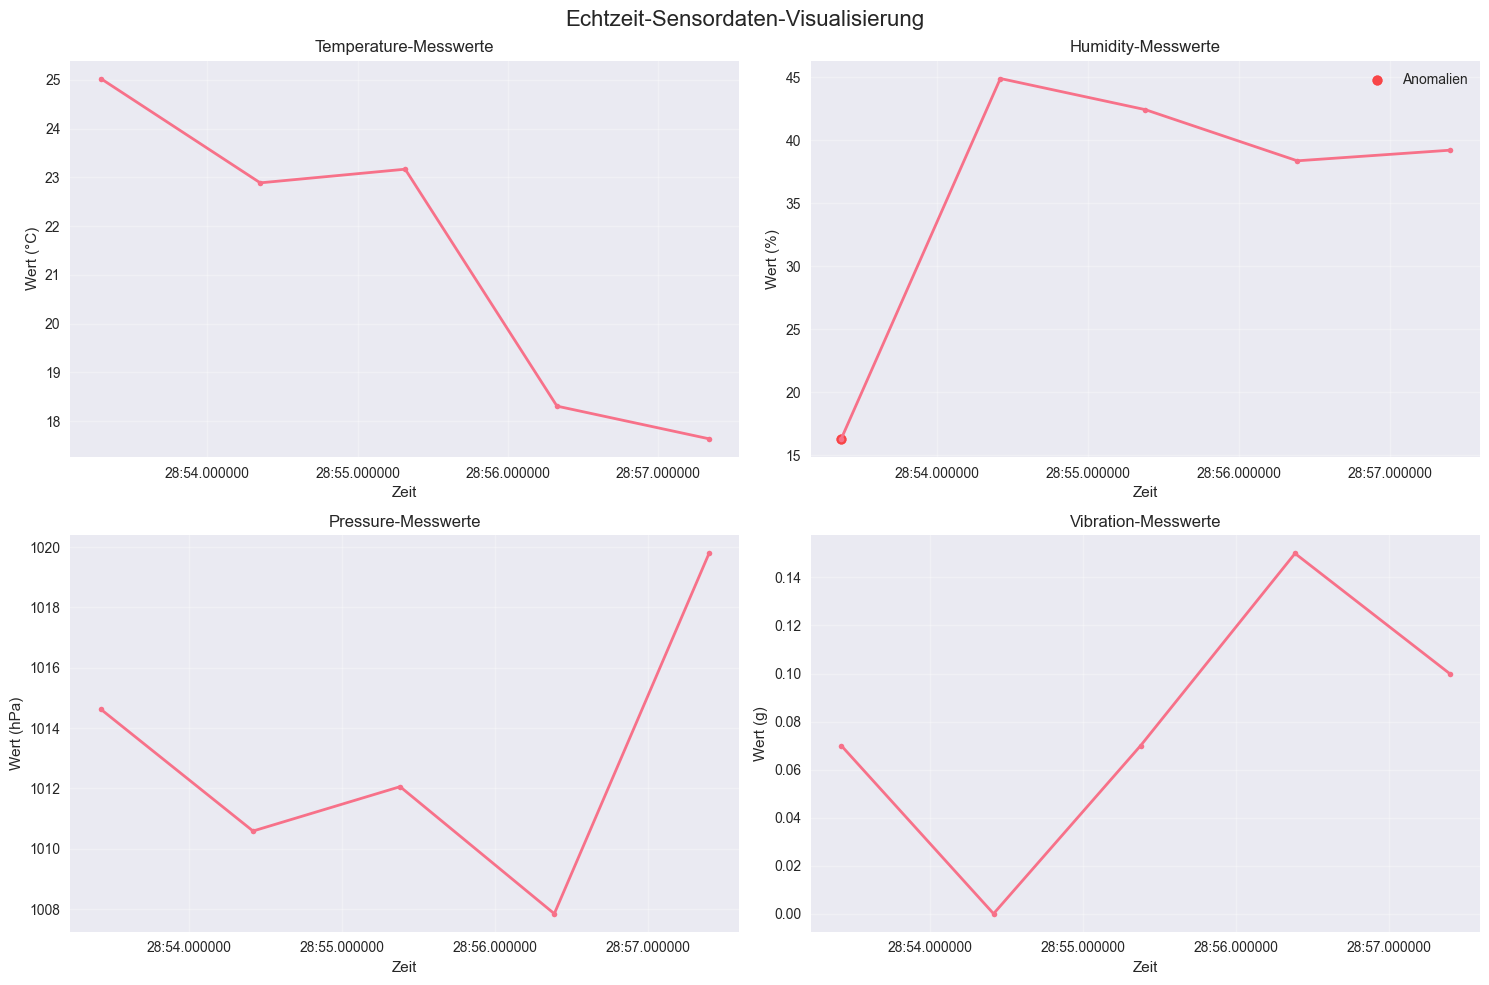


Zusammenfassende Statistiken nach Sensortyp:
             count     mean    std      min      max
sensor_type                                         
humidity         5    36.23  11.44    16.30    44.89
pressure         5  1012.98   4.53  1007.85  1019.79
temperature      5    21.41   3.25    17.64    25.03
vibration        5     0.08   0.05     0.00     0.15

Zusammenfassung der Anomalieerkennung:
             Anomalien  Gesamtmesswerte  Anomalie_Prozentsatz
sensor_type                                                  
humidity             1                5                  20.0
pressure             0                5                   0.0
temperature          0                5                   0.0
vibration            0                5                   0.0


In [7]:
# Datenvorverarbeitung und Visualisierung
if not df.empty:
    # Zeitstempel in datetime umwandeln
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['reading_time'] = pd.to_datetime(df['reading_time'])
    
    # Visualisierungen erstellen
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Echtzeit-Sensordaten-Visualisierung', fontsize=16)
    
    sensor_types = df['sensor_type'].unique()
    
    for i, sensor_type in enumerate(sensor_types[:4]):
        row = i // 2
        col = i % 2
        
        sensor_data_subset = df[df['sensor_type'] == sensor_type]
        
        # Zeitreihen-Plot
        axes[row, col].plot(sensor_data_subset['timestamp'], 
                           sensor_data_subset['value'], 
                           marker='o', linewidth=2, markersize=4)
        axes[row, col].set_title(f'{sensor_type.title()}-Messwerte')
        axes[row, col].set_xlabel('Zeit')
        axes[row, col].set_ylabel(f'Wert ({sensor_data_subset.iloc[0]["unit"]})')
        axes[row, col].grid(True, alpha=0.3)
        
        # Anomalien hervorheben
        anomalies = sensor_data_subset[sensor_data_subset['anomaly'] == True]
        if not anomalies.empty:
            axes[row, col].scatter(anomalies['timestamp'], 
                                 anomalies['value'], 
                                 color='red', s=50, alpha=0.7, 
                                 label='Anomalien')
            axes[row, col].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Zusammenfassende Statistiken
    print("\nZusammenfassende Statistiken nach Sensortyp:")
    summary_stats = df.groupby('sensor_type')['value'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(2)
    print(summary_stats)
    
    # Zusammenfassung der Anomalieerkennung
    print("\nZusammenfassung der Anomalieerkennung:")
    anomaly_summary = df.groupby('sensor_type')['anomaly'].agg([
        'sum', 'count', lambda x: (x.sum() / len(x) * 100)
    ])
    anomaly_summary.columns = ['Anomalien', 'Gesamtmesswerte', 'Anomalie_Prozentsatz']
    anomaly_summary['Anomalie_Prozentsatz'] = anomaly_summary['Anomalie_Prozentsatz'].round(2)
    print(anomaly_summary)

## 5. Machine-Learning-Pipeline {#ml-pipeline}

Jetzt erstellen wir eine Machine-Learning-Pipeline, um:
1. Anomalien in Sensordaten zu erkennen
2. Sensortypen basierend auf Messwerten zu klassifizieren
3. Zukünftige Sensorwerte vorherzusagen

### Was ist ein Klassifikator?
Ein Klassifikator ist eine Art von maschinellem Lernmodell, das verwendet wird, um einem Eingabedatenpunkt eine Klasse zuzuweisen. Zum Beispiel könnte ein Klassifikator verwendet werden, um festzustellen, ob eine E-Mail Spam ist oder nicht.

### Was ist ein Random Forest?
Ein Random Forest ist eine spezielle Art von Klassifikator. Es ist eine Ensemble-Lernmethode, die durch die Erstellung einer Vielzahl von Entscheidungsbäumen zur Trainingszeit arbeitet und die Klasse ausgibt, die der Modus der Klassen (Klassifikation) der einzelnen Bäume ist. Wir werden in den kommenden Kursen tiefer in dieses Thema eintauchen.

In [8]:
class SensorMLPipeline:
    def __init__(self):
        self.anomaly_detector = IsolationForest(contamination=0.1, random_state=42)
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.scaler = StandardScaler()
        self.is_trained = False
    
    def prepare_features(self, df):
        """Merkmale für das maschinelle Lernen vorbereiten"""
        if df.empty:
            return pd.DataFrame()
        
        # Merkmalsmatrix erstellen
        features_df = df.copy()
        
        # Zeitbasierte Merkmale
        features_df['hour'] = pd.to_datetime(features_df['timestamp']).dt.hour
        features_df['minute'] = pd.to_datetime(features_df['timestamp']).dt.minute
        
        # Gleitende Statistiken (wenn genügend Daten vorhanden sind)
        if len(features_df) > 5:
            features_df = features_df.sort_values('timestamp')
            features_df['rolling_mean_3'] = features_df.groupby('sensor_type')['value'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
            features_df['rolling_std_3'] = features_df.groupby('sensor_type')['value'].rolling(3, min_periods=1).std().fillna(0).reset_index(0, drop=True)
        else:
            features_df['rolling_mean_3'] = features_df['value']
            features_df['rolling_std_3'] = 0
        
        # Verzögerungsmerkmale (Lag-Features)
        features_df['value_lag1'] = features_df.groupby('sensor_type')['value'].shift(1).fillna(features_df['value'])
        
        return features_df
    
    def train_anomaly_detector(self, df):
        """Anomalieerkennungsmodell trainieren"""
        features_df = self.prepare_features(df)
        
        if features_df.empty:
            print("Keine Daten zum Trainieren verfügbar")
            return
        
        # Merkmale für die Anomalieerkennung auswählen
        feature_cols = ['value', 'hour', 'minute', 'rolling_mean_3', 'rolling_std_3', 'value_lag1']
        X = features_df[feature_cols].fillna(0)
        
        # Merkmale skalieren
        X_scaled = self.scaler.fit_transform(X)
        
        # Anomalieerkennungsmodell trainieren
        self.anomaly_detector.fit(X_scaled)
        
        print("Anomalieerkennungsmodell erfolgreich trainiert")
        return X_scaled
    
    def train_classifier(self, df):
        """Sensortyp-Klassifikator trainieren"""
        features_df = self.prepare_features(df)
        
        if features_df.empty:
            print("Keine Daten zum Trainieren verfügbar")
            return
        
        # Merkmale für die Klassifizierung auswählen
        feature_cols = ['value', 'hour', 'minute', 'rolling_mean_3', 'rolling_std_3', 'value_lag1']
        X = features_df[feature_cols].fillna(0)
        y = features_df['sensor_type']
        
        # Daten aufteilen
        if len(X) > 10:  # Nur aufteilen, wenn genügend Daten vorhanden sind
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        else:
            X_train, X_test, y_train, y_test = X, X, y, y
        
        # Klassifikator trainieren
        self.classifier.fit(X_train, y_train)
        
        # Evaluieren
        y_pred = self.classifier.predict(X_test)
        
        print("Sensortyp-Klassifikator erfolgreich trainiert")
        print("\nKlassifizierungsbericht:")
        print(classification_report(y_test, y_pred))
        
        self.is_trained = True
        return X_train, X_test, y_train, y_test, y_pred
    
    def detect_anomalies(self, df):
        """Anomalien in neuen Daten erkennen"""
        features_df = self.prepare_features(df)
        
        if features_df.empty:
            return pd.DataFrame()
        
        feature_cols = ['value', 'hour', 'minute', 'rolling_mean_3', 'rolling_std_3', 'value_lag1']
        X = features_df[feature_cols].fillna(0)
        
        # Merkmale skalieren
        X_scaled = self.scaler.transform(X)
        
        # Anomalien vorhersagen (-1 = Anomalie, 1 = normal)
        anomaly_predictions = self.anomaly_detector.predict(X_scaled)
        anomaly_scores = self.anomaly_detector.score_samples(X_scaled)
        
        features_df['predicted_anomaly'] = anomaly_predictions == -1
        features_df['anomaly_score'] = anomaly_scores
        
        return features_df
    
    def predict_sensor_type(self, df):
        """Sensortyp für neue Daten vorhersagen"""
        if not self.is_trained:
            print("Modell noch nicht trainiert")
            return None
        
        features_df = self.prepare_features(df)
        
        if features_df.empty:
            return pd.DataFrame()
        
        feature_cols = ['value', 'hour', 'minute', 'rolling_mean_3', 'rolling_std_3', 'value_lag1']
        X = features_df[feature_cols].fillna(0)
        
        # Sensortypen vorhersagen
        predictions = self.classifier.predict(X)
        probabilities = self.classifier.predict_proba(X)
        
        features_df['predicted_sensor_type'] = predictions
        
        return features_df

# ML-Pipeline initialisieren
ml_pipeline = SensorMLPipeline()
print("Machine-Learning-Pipeline initialisiert")

Machine-Learning-Pipeline initialisiert


### Trainieren der Machine-Learning-Modelle

Trainieren wir unsere Modelle mit den gesammelten Sensordaten.

In [9]:
# Modelle trainieren, wenn Daten vorhanden sind
if not df.empty:
    print("Trainiere Anomalieerkennungsmodell...")
    ml_pipeline.train_anomaly_detector(df)
    
    print("\nTrainiere Sensortyp-Klassifikator...")
    ml_pipeline.train_classifier(df)
    
    print("\nModelle erfolgreich trainiert!")
else:
    print("Keine Daten zum Trainieren verfügbar. Bitte führen Sie zuerst den Abschnitt zur Datenerfassung aus.")

Trainiere Anomalieerkennungsmodell...
Anomalieerkennungsmodell erfolgreich trainiert

Trainiere Sensortyp-Klassifikator...
Sensortyp-Klassifikator erfolgreich trainiert

Klassifizierungsbericht:
              precision    recall  f1-score   support

    humidity       1.00      1.00      1.00         2
    pressure       1.00      1.00      1.00         1
 temperature       1.00      1.00      1.00         2
   vibration       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Modelle erfolgreich trainiert!
Sensortyp-Klassifikator erfolgreich trainiert

Klassifizierungsbericht:
              precision    recall  f1-score   support

    humidity       1.00      1.00      1.00         2
    pressure       1.00      1.00      1.00         1
 temperature       1.00      1.00      1.00         2
   vibration       1.00      1.00      1.00      

Führe Anomalieerkennung auf gesammelten Daten durch...

Ergebnisse der Anomalieerkennung:
    sensor_type    value  true_anomaly  predicted_anomaly  anomaly_score
0   temperature    25.03         False              False      -0.453726
1      humidity    16.30          True              False      -0.469218
2      pressure  1014.63         False              False      -0.614769
3     vibration     0.07         False              False      -0.443042
4   temperature    22.89         False              False      -0.426063
5      humidity    44.89         False               True      -0.631588
6      pressure  1010.59         False              False      -0.554610
7     vibration     0.00         False              False      -0.441974
8   temperature    23.17         False              False      -0.422332
11    vibration     0.07         False              False      -0.440296

Genauigkeit der Anomalieerkennung: 85.00%


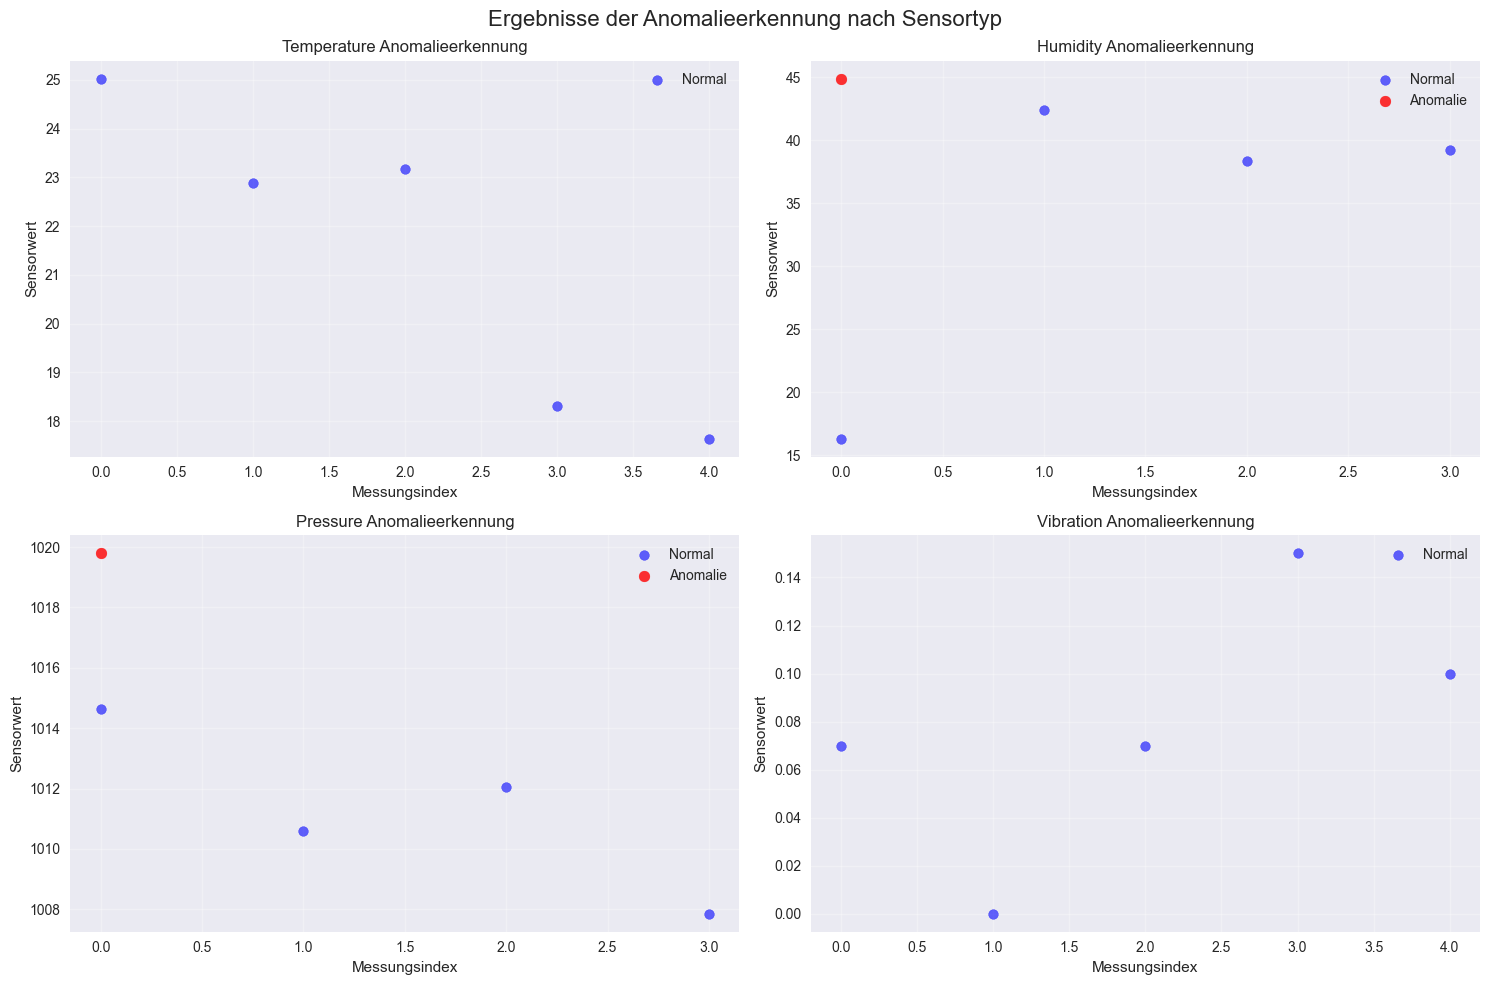

In [10]:
# Anomalieerkennung demonstrieren
if not df.empty and ml_pipeline.is_trained:
    print("Führe Anomalieerkennung auf gesammelten Daten durch...")
    
    # Anomalien erkennen
    anomaly_results = ml_pipeline.detect_anomalies(df)
    
    # Echte vs. vorhergesagte Anomalien vergleichen
    comparison = pd.DataFrame({
        'sensor_type': anomaly_results['sensor_type'],
        'value': anomaly_results['value'],
        'true_anomaly': anomaly_results['anomaly'],
        'predicted_anomaly': anomaly_results['predicted_anomaly'],
        'anomaly_score': anomaly_results['anomaly_score']
    })
    
    print("\nErgebnisse der Anomalieerkennung:")
    print(comparison.head(10))
    
    # Genauigkeit berechnen
    accuracy = (comparison['true_anomaly'] == comparison['predicted_anomaly']).mean()
    print(f"\nGenauigkeit der Anomalieerkennung: {accuracy:.2%}")
    
    # Ergebnisse der Anomalieerkennung visualisieren
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Ergebnisse der Anomalieerkennung nach Sensortyp', fontsize=16)
    
    for i, sensor_type in enumerate(anomaly_results['sensor_type'].unique()[:4]):
        row = i // 2
        col = i % 2
        
        sensor_subset = anomaly_results[anomaly_results['sensor_type'] == sensor_type]
        
        # Normale Punkte plotten
        normal_points = sensor_subset[~sensor_subset['predicted_anomaly']]
        axes[row, col].scatter(range(len(normal_points)), normal_points['value'], 
                              c='blue', alpha=0.6, label='Normal')
        
        # Anomalien plotten
        anomaly_points = sensor_subset[sensor_subset['predicted_anomaly']]
        if not anomaly_points.empty:
            axes[row, col].scatter(range(len(anomaly_points)), anomaly_points['value'], 
                                  c='red', alpha=0.8, label='Anomalie', s=60)
        
        axes[row, col].set_title(f'{sensor_type.title()} Anomalieerkennung')
        axes[row, col].set_xlabel('Messungsindex')
        axes[row, col].set_ylabel('Sensorwert')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Echtzeit-Vorhersagesystem {#real-time}

Erstellen wir nun ein Echtzeitsystem, das eingehende MQTT-Daten verarbeiten und Vorhersagen treffen kann.

In [11]:
class RealTimeMQTTMLSystem:
    def __init__(self, ml_pipeline, mqtt_collector):
        self.ml_pipeline = ml_pipeline
        self.mqtt_collector = mqtt_collector
        self.predictions = []
        self.running = False
    
    def process_real_time_data(self, duration_seconds=30):
        """Eingehende MQTT-Daten in Echtzeit verarbeiten"""
        self.running = True
        start_time = time.time()
        
        print(f"Starte Echtzeitverarbeitung für {duration_seconds} Sekunden...")
        
        while self.running and (time.time() - start_time) < duration_seconds:
            # Neueste Daten abrufen
            current_data = self.mqtt_collector.get_data_as_dataframe()
            
            if not current_data.empty and len(current_data) > 0:
                # Die aktuellsten Messwerte abrufen
                recent_data = current_data.tail(4)  # Letzte 4 Messwerte
                
                if self.ml_pipeline.is_trained:
                    # Anomalien erkennen
                    anomaly_results = self.ml_pipeline.detect_anomalies(recent_data)
                    
                    # Jede aktuelle Messung verarbeiten
                    for _, row in anomaly_results.iterrows():
                        prediction = {
                            'timestamp': row['timestamp'],
                            'sensor_type': row['sensor_type'],
                            'value': row['value'],
                            'predicted_anomaly': row['predicted_anomaly'],
                            'anomaly_score': row['anomaly_score']
                        }
                        
                        self.predictions.append(prediction)
                        
                        # Alarmieren, wenn eine Anomalie erkannt wird
                        if row['predicted_anomaly']:
                            print(f"🚨 ANOMALIE ERKANNT: {row['sensor_type']} = {row['value']} (Score: {row['anomaly_score']:.3f})")
                        else:
                            print(f"✅ Normal: {row['sensor_type']} = {row['value']}")
            
            time.sleep(2)  # Alle 2 Sekunden prüfen
        
        self.running = False
        print("\nEchtzeitverarbeitung abgeschlossen!")
    
    def get_predictions_summary(self):
        """Zusammenfassung der getroffenen Vorhersagen abrufen"""
        if not self.predictions:
            return "Noch keine Vorhersagen getroffen"
        
        pred_df = pd.DataFrame(self.predictions)
        
        summary = {
            'total_predictions': len(pred_df),
            'anomalies_detected': pred_df['predicted_anomaly'].sum(),
            'anomaly_rate': pred_df['predicted_anomaly'].mean() * 100,
            'sensors_monitored': pred_df['sensor_type'].nunique()
        }
        
        return summary

# Echtzeitsystem erstellen
if ml_pipeline.is_trained:
    realtime_system = RealTimeMQTTMLSystem(ml_pipeline, collector)
    print("Echtzeit-MQTT-ML-System initialisiert")
else:
    print("Bitte trainieren Sie zuerst die ML-Pipeline")

Echtzeit-MQTT-ML-System initialisiert


### Beispiel: Echtzeit-Verarbeitungsdemo

Demonstrieren wir das Echtzeitsystem, indem wir neue Sensordaten generieren und live verarbeiten.

In [12]:
# Echtzeitverarbeitung demonstrieren
if 'realtime_system' in locals() and ml_pipeline.is_trained:
    print("Starte Echtzeit-Demo...")
    
    # Neue Daten im Hintergrund veröffentlichen
    def publish_demo_data():
        publisher.publish_sensor_data(duration_seconds=35, interval_seconds=1.5)
    
    # Echtzeitverarbeitung im Hintergrund starten
    def process_demo_data():
        realtime_system.process_real_time_data(duration_seconds=30)
    
    # Beide parallel ausführen
    publish_thread = threading.Thread(target=publish_demo_data)
    process_thread = threading.Thread(target=process_demo_data)
    
    publish_thread.start()
    time.sleep(1)  # Kleine Verzögerung
    process_thread.start()
    
    # Auf Abschluss warten
    process_thread.join()
    publish_thread.join()
    
    # Zusammenfassung anzeigen
    summary = realtime_system.get_predictions_summary()
    print("\n" + "="*50)
    print("ZUSAMMENFASSUNG DER ECHTZEITVERARBEITUNG")
    print("="*50)
    for key, value in summary.items():
        print(f"{key.replace('_', ' ').title()}: {value}")
else:
    print("Echtzeitsystem nicht verfügbar. Bitte führen Sie zuerst die vorherigen Abschnitte aus.")

Starte Echtzeit-Demo...
Beginne mit der Veröffentlichung von Sensordaten für 35 Sekunden...
Veröffentlicht temperature: 19.86 °C
Veröffentlicht humidity: 41.47 %
Veröffentlicht pressure: 1014.42 hPa
Veröffentlicht vibration: 0.06 g
Starte Echtzeitverarbeitung für 30 Sekunden...
✅ Normal: temperature = 19.86
✅ Normal: humidity = 41.47
✅ Normal: pressure = 1014.42
✅ Normal: vibration = 0.06
Starte Echtzeitverarbeitung für 30 Sekunden...
✅ Normal: temperature = 19.86
✅ Normal: humidity = 41.47
✅ Normal: pressure = 1014.42
✅ Normal: vibration = 0.06
Veröffentlicht temperature: 26.56 °C
Veröffentlicht humidity: 53.94 %
Veröffentlicht pressure: 1012.38 hPa
Veröffentlicht vibration: 0.17 g
Veröffentlicht temperature: 26.56 °C
Veröffentlicht humidity: 53.94 %
Veröffentlicht pressure: 1012.38 hPa
Veröffentlicht vibration: 0.17 g
Veröffentlicht temperature: 27.02 °C
Veröffentlicht humidity: 85.48 %
Veröffentlicht pressure: 1006.8 hPa
Veröffentlicht vibration: 0.05 g
✅ Normal: temperature = 26.56

## 7. Übungsaufgaben {#practice}

Jetzt ist es Zeit zu üben! Hier sind einige Übungen, um Ihr Verständnis zu testen.

### Übungsaufgabe 1: Integration eines benutzerdefinierten Sensors

**Aufgabe**: Fügen Sie einen neuen Sensortyp namens "Licht" hinzu, der die Lichtintensität (0-1000 Lux) misst.

**Anforderungen**:
1. Fügen Sie den neuen Sensor zum `TOPICS`-Wörterbuch hinzu
2. Aktualisieren Sie den `MockSensorPublisher`, um Lichtsensordaten zu generieren
3. Sammeln Sie Daten für diesen neuen Sensor
4. Trainieren Sie die ML-Modelle neu, um den neuen Sensortyp einzubeziehen

**Starter-Code**:

In [13]:
# Übungsaufgabe 1 - Fügen Sie hier Ihre Lösung ein

# Schritt 1: Lichtsensor zu den Themen hinzufügen
TOPICS_EXTENDED = TOPICS.copy()
# TODO: Fügen Sie 'light': 'tutorial/sensors/light' zu TOPICS_EXTENDED hinzu

# Schritt 2: Sensorparameter aktualisieren
# TODO: Fügen Sie Lichtsensorparameter hinzu (mean=500, std=100, min=0, max=1000)

# Schritt 3: Neuen Publisher mit erweiterten Themen erstellen
# TODO: Erstellen Sie publisher_extended = MockSensorPublisher(...)

# Schritt 4: Daten sammeln und Modelle neu trainieren
# TODO: Implementieren Sie die Datenerfassung und das Neutrainieren der Modelle

print("Übungsaufgabe 1 - Implementieren Sie die obige Lösung!")

Übungsaufgabe 1 - Implementieren Sie die obige Lösung!


### Übungsaufgabe 2: Fortgeschrittene Anomalieerkennung

**Aufgabe**: Implementieren Sie ein anspruchsvolleres Anomalieerkennungssystem, das Folgendes berücksichtigt:
1. Korrelationen zwischen Sensoren (z. B. sind Temperatur und Luftfeuchtigkeit oft korreliert)
2. Zeitbasierte Muster (z. B. variiert die Temperatur je nach Tageszeit)
3. Saisonale Trends

**Anforderungen**:
1. Erstellen Sie Merkmale, die Sensorkorrelationen erfassen
2. Fügen Sie zeitbasierte Merkmale hinzu (Stunde, Wochentag usw.)
3. Implementieren Sie einen Anomalie-Detektor für mehrere Sensoren
4. Vergleichen Sie die Leistung mit dem einfachen Anomalie-Detektor

In [14]:
# Übungsaufgabe 2 - Fügen Sie hier Ihre Lösung ein

class AdvancedAnomalyDetector:
    def __init__(self):
        # TODO: Initialisieren Sie Ihren fortgeschrittenen Anomalie-Detektor
        pass
    
    def create_advanced_features(self, df):
        """Erstellen Sie fortgeschrittene Merkmale für die Anomalieerkennung"""
        # TODO: Implementieren Sie fortgeschrittenes Feature-Engineering
        # Hinweise:
        # - Daten pivotieren, um Sensoren als Spalten zu haben
        # - Korrelationen zwischen Sensoren berechnen
        # - Zyklische Zeitmerkmale hinzufügen (sin/cos der Stunde)
        # - Gleitende Statistiken über mehrere Sensoren hinzufügen
        pass
    
    def train(self, df):
        """Trainieren Sie den fortgeschrittenen Anomalie-Detektor"""
        # TODO: Implementieren Sie die Trainingslogik
        pass
    
    def predict(self, df):
        """Anomalien mit fortgeschrittenen Merkmalen vorhersagen"""
        # TODO: Implementieren Sie die Vorhersagelogik
        pass

print("Übungsaufgabe 2 - Implementieren Sie die Klasse AdvancedAnomalyDetector!")

Übungsaufgabe 2 - Implementieren Sie die Klasse AdvancedAnomalyDetector!


### Übungsaufgabe 3: Vorausschauendes Wartungssystem

**Aufgabe**: Erstellen Sie ein vorausschauendes Wartungssystem, das:
1. Vorhersagt, wann ein Sensor aufgrund seiner Messwerte ausfallen könnte
2. Die verbleibende Nutzungsdauer (RUL) von Geräten schätzt
3. Wartungswarnungen sendet, bevor Ausfälle auftreten

**Anforderungen**:
1. Erstellen Sie synthetische Ausfalldaten (simulieren Sie die Sensoralterung)
2. Erstellen Sie ein Regressionsmodell zur Vorhersage der RUL
3. Implementieren Sie Alarmschwellen
4. Erstellen Sie ein Dashboard, das den Zustand der Geräte anzeigt

In [15]:
# Übungsaufgabe 3 - Fügen Sie hier Ihre Lösung ein

class PredictiveMaintenanceSystem:
    def __init__(self):
        # TODO: Initialisieren Sie Ihr vorausschauendes Wartungssystem
        pass
    
    def simulate_sensor_degradation(self, df):
        """Sensoralterung im Laufe der Zeit simulieren"""
        # TODO: Alterungsmuster zu den Sensordaten hinzufügen
        # Hinweise:
        # - Rauschen hinzufügen, das im Laufe der Zeit zunimmt
        # - Drift in den Sensormesswerten simulieren
        # - Ausfallereignisse erstellen
        pass
    
    def calculate_health_score(self, df):
        """Gerätezustandsbewertung (0-100) berechnen"""
        # TODO: Implementieren Sie die Berechnung der Zustandsbewertung
        # Berücksichtigen Sie: Sensorgenauigkeit, Stabilität, Anomaliefrequenz
        pass
    
    def predict_remaining_life(self, df):
        """Verbleibende Nutzungsdauer in Tagen vorhersagen"""
        # TODO: Implementieren Sie die RUL-Vorhersage
        pass
    
    def generate_maintenance_alerts(self, health_scores, rul_predictions):
        """Wartungswarnungen basierend auf Vorhersagen generieren"""
        # TODO: Implementieren Sie die Alarmlogik
        # Alarmstufen: Grün (>80), Gelb (50-80), Rot (<50)
        pass

print("Übungsaufgabe 3 - Implementieren Sie die Klasse PredictiveMaintenanceSystem!")

Übungsaufgabe 3 - Implementieren Sie die Klasse PredictiveMaintenanceSystem!


### Übungsaufgabe 4: Edge-Computing-Integration

**Aufgabe**: Simulieren Sie ein Edge-Computing-Szenario, in dem:
1. Lokale Verarbeitung die Datenübertragung reduziert
2. Nur wichtige Ereignisse an die Cloud gesendet werden
3. Modelle lokal ausgeführt werden und regelmäßig Updates aus der Cloud erhalten

**Anforderungen**:
1. Implementieren Sie eine Logik für lokale vs. Cloud-Verarbeitung
2. Erstellen Sie eine Datenfilterung basierend auf der Wichtigkeit
3. Simulieren Sie die Modell-Synchronisation
4. Vergleichen Sie die Bandbreitennutzung mit/ohne Edge-Verarbeitung

In [16]:
# Übungsaufgabe 4 - Fügen Sie hier Ihre Lösung ein

class EdgeComputingSystem:
    def __init__(self, ml_pipeline):
        self.local_model = ml_pipeline
        self.cloud_model = None
        self.bandwidth_usage = {'local': 0, 'cloud': 0}
        
    def process_locally(self, sensor_data):
        """Daten lokal auf dem Edge-Gerät verarbeiten"""
        # TODO: Implementieren Sie die lokale Verarbeitung
        # - Anomalieerkennung lokal ausführen
        # - Daten nach Wichtigkeit filtern
        # - Bandbreiteneinsparungen verfolgen
        pass
    
    def send_to_cloud(self, filtered_data):
        """Nur wichtige Daten an die Cloud senden"""
        # TODO: Implementieren Sie die Cloud-Kommunikation
        # - Netzwerkübertragung simulieren
        # - Bandbreitennutzung verfolgen
        pass
    
    def sync_models(self):
        """Lokales Modell mit Cloud-Updates synchronisieren"""
        # TODO: Implementieren Sie die Modell-Synchronisation
        pass
    
    def calculate_bandwidth_savings(self):
        """Bandbreiteneinsparungen durch Edge-Verarbeitung berechnen"""
        # TODO: Bandbreitennutzung mit/ohne Edge-Verarbeitung vergleichen
        pass

print("Übungsaufgabe 4 - Implementieren Sie die Klasse EdgeComputingSystem!")

Übungsaufgabe 4 - Implementieren Sie die Klasse EdgeComputingSystem!


## Lösungen und Diskussion

### Tipps für die Übungsaufgaben:

1. **Aufgabe 1 (Benutzerdefinierter Sensor)**:
   - Denken Sie daran, sowohl den Publisher als auch den Collector zu aktualisieren
   - Lichtsensoren haben typischerweise andere Eigenschaften als andere Sensoren
   - Berücksichtigen Sie, wie das Licht im Laufe des Tages variiert

2. **Aufgabe 2 (Fortgeschrittene Anomalieerkennung)**:
   - Verwenden Sie `pd.pivot_table()`, um Daten für die sensorübergreifende Analyse umzuformen
   - Zyklische Merkmale: `np.sin(2 * np.pi * stunde / 24)`
   - Erwägen Sie die Verwendung von Ensemble-Methoden oder Deep-Learning-Ansätzen

3. **Aufgabe 3 (Vorausschauende Wartung)**:
   - Simulieren Sie die Alterung durch zunehmendes Rauschen im Laufe der Zeit
   - Verwenden Sie Regressionsmodelle (Random Forest, XGBoost) für die RUL-Vorhersage
   - Zustandsbewertungen können mehrere Metriken kombinieren (Genauigkeit, Stabilität, Trend)

4. **Aufgabe 4 (Edge Computing)**:
   - Konzentrieren Sie sich auf Datenkompressions- und Filterstrategien
   - Berücksichtigen Sie den Kompromiss zwischen Latenz und Genauigkeit
   - Modellquantisierung kann die Modellgröße für den Einsatz am Edge reduzieren

### Nächste Schritte:

1. **Produktions-Deployment**:
   - Verwenden Sie sichere MQTT-Broker (TLS/SSL)
   - Implementieren Sie eine ordnungsgemäße Authentifizierung und Autorisierung
   - Fügen Sie Datenpersistenz hinzu (Datenbanken)
   - Richten Sie Überwachung und Alarmierung ein

2. **Skalierungsüberlegungen**:
   - Verwenden Sie Nachrichtenwarteschlangen für Szenarien mit hohem Durchsatz
   - Implementieren Sie Lastausgleich für mehrere Verbraucher
   - Erwägen Sie Stream-Processing-Frameworks (Apache Kafka, Apache Flink)

3. **Fortgeschrittene ML-Techniken**:
   - Online-Lernen für Modell-Updates
   - Deep Learning für komplexe Mustererkennung
   - Föderiertes Lernen für verteilte Szenarien
   - AutoML für die automatisierte Modellauswahl und -abstimmung

## Aufräumen

Vergessen Sie nicht, die Verbindung zum MQTT-Broker zu trennen, wenn Sie fertig sind!

In [17]:
# Verbindungen aufräumen
try:
    collector.disconnect()
    publisher.disconnect()
    print("Erfolgreich vom MQTT-Broker getrennt")
except:
    print("Aufräumen abgeschlossen")

Vom MQTT-Broker getrennt
Erfolgreich vom MQTT-Broker getrennt
Erfolgreich vom MQTT-Broker getrennt
